<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------

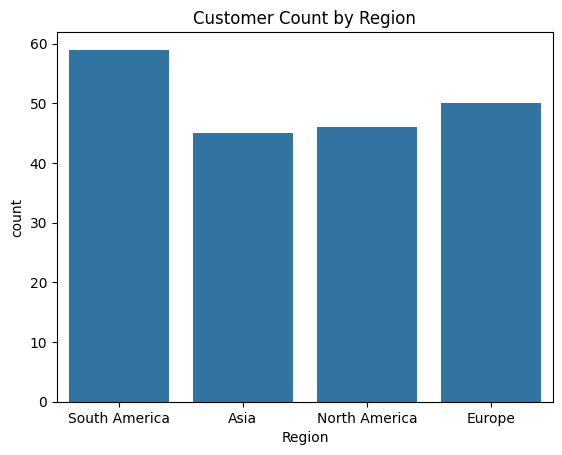

<ipython-input-1-5d8fa61b9f52>:30: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Category', y='Price', data=products, ci=None)


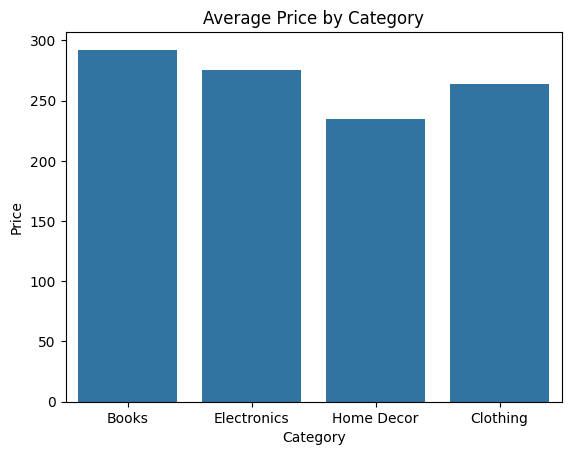

<ipython-input-1-5d8fa61b9f52>:38: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='TransactionDate', y='TotalValue', data=merged_data, ci=None)


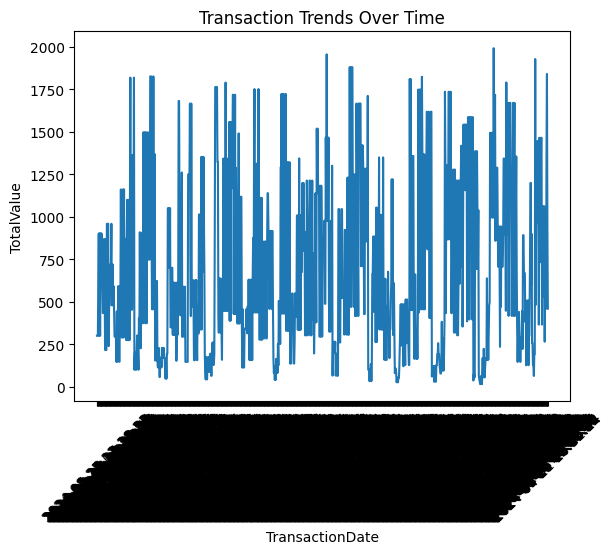

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Overview of data
print(customers.info())
print(products.info())
print(transactions.info())

# Check for missing values
print(customers.isnull().sum())
print(products.isnull().sum())
print(transactions.isnull().sum())

# Summary statistics
print(customers.describe())
print(products.describe())
print(transactions.describe())

# Exploratory Visualizations
sns.countplot(x='Region', data=customers)
plt.title('Customer Count by Region')
plt.show()

sns.barplot(x='Category', y='Price', data=products, ci=None)
plt.title('Average Price by Category')
plt.show()

# Merge datasets for deeper analysis
merged_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

# Transaction trends over time
sns.lineplot(x='TransactionDate', y='TotalValue', data=merged_data, ci=None)
plt.title('Transaction Trends Over Time')
plt.xticks(rotation=45)
plt.show()

# Save merged data for further use
merged_data.to_csv('Merged_Data.csv', index=False)


In [ ]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load merged data
merged_data = pd.read_csv('Merged_Data.csv')

# Feature engineering
customer_profiles = merged_data.groupby('CustomerID').agg({
    'Category': lambda x: ' '.join(x),
    'TotalValue': 'sum'
}).reset_index()

# Encode and scale features
encoded_categories = pd.get_dummies(customer_profiles['Category'])
scaler = StandardScaler()
scaled_values = scaler.fit_transform(customer_profiles[['TotalValue']])
features = np.hstack((encoded_categories.values, scaled_values))

# Cosine similarity
similarity_matrix = cosine_similarity(features)

# Generate lookalikes for first 20 customers
lookalikes = {}
customer_ids = customer_profiles['CustomerID']

for i, customer_id in enumerate(customer_ids[:20]):
    scores = list(enumerate(similarity_matrix[i]))
    scores = sorted(scores, key=lambda x: x[1], reverse=True)[1:4]
    lookalikes[customer_id] = [(customer_ids[idx], round(score, 4)) for idx, score in scores]

# Save lookalikes to CSV
lookalike_output = [{'CustomerID': cust, 'Recommendations': str(rec)} for cust, rec in lookalikes.items()]
pd.DataFrame(lookalike_output).to_csv('Gopika_T_Lookalike.csv', index=False)


Davies-Bouldin Index: 0.72127971818163


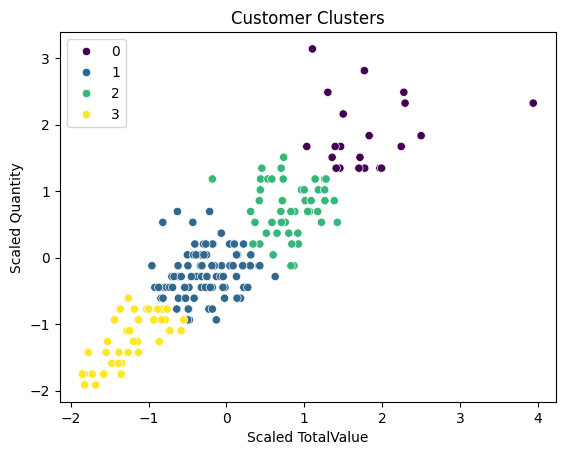

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load merged data
merged_data = pd.read_csv('Merged_Data.csv')

# Prepare data for clustering
features = merged_data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'Quantity': 'sum'
}).reset_index()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features[['TotalValue', 'Quantity']])

# Apply clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_features)
features['Cluster'] = clusters

# Evaluate clusters
db_index = davies_bouldin_score(scaled_features, clusters)
print(f'Davies-Bouldin Index: {db_index}')

# Visualize clusters
sns.scatterplot(x=scaled_features[:, 0], y=scaled_features[:, 1], hue=clusters, palette='viridis')
plt.title('Customer Clusters')
plt.xlabel('Scaled TotalValue')
plt.ylabel('Scaled Quantity')
plt.show()

# Save cluster results
features.to_csv('Gopika_T_Clustering.pdf', index=False)
